# CRF-CORA

This file is the first attempt at using pystruct.GraphCRF to do CRF for the clean cora dataset

In [15]:
#   Resource stopwords not found.
#   Please use the NLTK Downloader to obtain the resource:
## ONLY DO THIS ONCE
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davina/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
import pickle
import gensim

from pystruct.models import GraphCRF
from pystruct.learners import OneSlackSSVM
from gensim.models import Word2Vec

In [17]:
data_path = './data/'

In [18]:
with open(data_path+'cleaned_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

for id in data['features_for_id']:
    sentence = ""
    for feature in data['features_for_id'][id]:
        word = feature.split('=')[1]
        if word == 'missing':
            continue
        else:
            sentence += feature.split('=')[1] + ' '
    data['features_for_id'][id] = sentence.strip()

In [ ]:
features_list = [data['features_for_id'][id].split() for id in data['features_for_id']]

In [20]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

for i in range(len(features_list)):
    features_list[i] = [word.lower() for word in features_list[i] if word.isalpha()]
    features_list[i] = [word for word in features_list[i] if not word in stop_words]

In [21]:
model = Word2Vec(features_list, min_count=1)

In [22]:
print(model)

Word2Vec(vocab=21669, size=100, alpha=0.025)


In [ ]:
words = list(model.wv.vocab)
print(words)

In [35]:
# Reference: https://nbviewer.jupyter.org/github/chambliss/Notebooks/blob/master/Word2Vec_News_Analysis.ipynb

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.wv.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [36]:
# Treat: author + title + years = overall title
# Then to word to vec

titles_list = [' '.join(title) for title in features_list]
# Preprocess the corpus
# corpus = [preprocess(title) for title in titles_list]
corpus = [title for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

83 docs removed
0 docs removed


In [38]:
import numpy as np
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

/Users/davina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


/Users/davina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


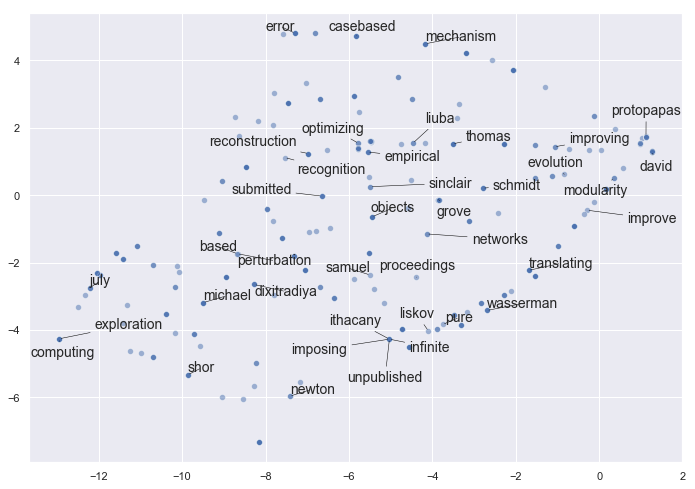

In [52]:
# visualization for words

from sklearn.manifold import TSNE
import pandas as pd
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

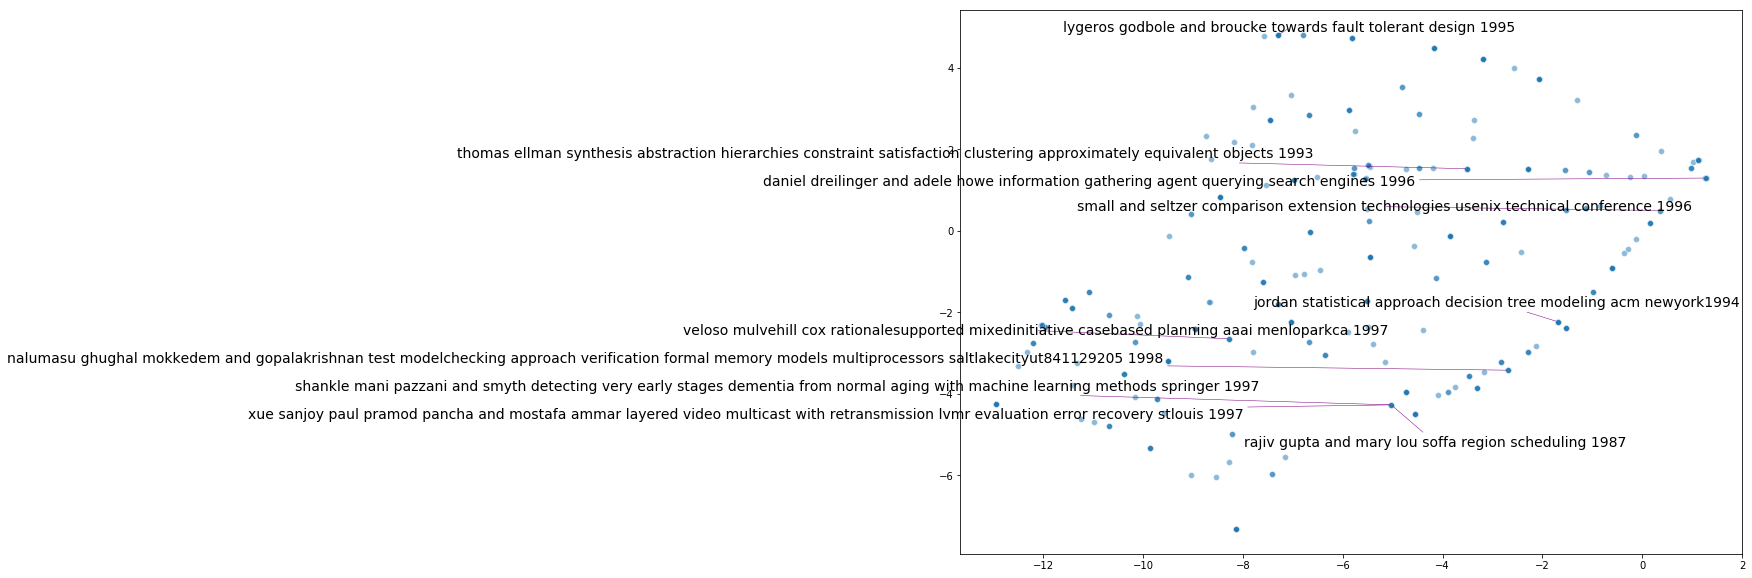

<Figure size 432x288 with 0 Axes>

In [49]:
# visualization For sentences
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()
plt.savefig('plot')